In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.collocations import *
from nltk import word_tokenize
from nltk.corpus import stopwords 
import string
from nltk.tokenize import RegexpTokenizer
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, recall_score, precision_score, average_precision_score, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels








In [2]:
reviews = pd.read_csv("Complete_reviews.csv")

/hpc/applications/anaconda/3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (15,200,201) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def analyze_business(popular_id, data, min_ngram = 2, max_ngram = 2, 
                     min_doc_freq = .001, max_doc_freq = 0.7, pos_or_neg = 'pos',
                    normalize = False, title = None,
                    cmap=plt.cm.Blues):
    data_sample = data[data['business_id'] == popular_id]
    data_text = data_sample['text'].copy()

    data_stars = data_sample['stars'].copy()
    data_stars = data_stars - 1

    clean_data = data_sample.drop(['Unnamed: 0', 'Unnamed: 0.1', 'business_id', "date", 'text',
                      'review_id', 'stars', 'user_id', 'name', 'Unnamed: 0_y',
                      'postal_code', "BestNights_business_id", "Music", 'latitude',
                      'longitude'],
                axis = 1)

    clean_data.rename({'stars.1': 'avg_stars'}, inplace =True)
    cols = clean_data.columns
    clean_data = np.nan_to_num(clean_data)
    clean_data = pd.DataFrame(clean_data)

    data_sparse = sparse.csr_matrix(clean_data.astype(float))

    vectorizer = TfidfVectorizer(stop_words = "english",
                                max_df = max_doc_freq,
                                min_df = min_doc_freq,
                                token_pattern = '[A-Za-z][A-Za-z]+',
                                ngram_range = (min_ngram, max_ngram))

    tfidf = vectorizer.fit_transform(data_text)
    full_sparse_matrix = sparse.hstack([data_sparse, tfidf])

    text_features = vectorizer.get_feature_names()
    # text_features = [w + '_' for w in text_features]
    nontext_features = cols

    features = np.concatenate((np.array(nontext_features, dtype = np.object), text_features), axis = None)
    features = features.tolist()
    # np.savetxt('scratch/tfidf_features_names_digrams_lr_' + popular_id + '.txt', features, delimiter = ',', fmt = '%s' )
    print(popular_id)
    print("Length of Vocabulary: " + str(len(vectorizer.get_feature_names())))
    X_train, X_test, y_train, y_test = train_test_split(full_sparse_matrix, data_stars, 
                                                        test_size = 0.4, random_state = 70)

    LR_clf = LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                                intercept_scaling=1, max_iter=10000, multi_class='multinomial',
                                n_jobs=None, penalty='l2', random_state=50, solver='newton-cg',
                                tol=0.005, verbose=0, warm_start=False)
    LR_clf.fit(X_train, y_train)
    LR_preds = LR_clf.predict(X_test) + 1
    y_test += 1

    print("Logistic Regression Performance: ")
    print( "Accuracy: "+ str(accuracy_score(LR_preds, y_test)))
    plot_confusion_matrix(y_test, LR_preds, title = title, normalize = normalize, cmap = cmap)
    feat = features
    coef = LR_clf.coef_
#     dic = dict(zip(feat, coef[0]))
#     sorted_by_value = sorted(dic.items(), key=lambda kv: kv[1], reverse = 1)
#     imp_feats = sorted_by_value[:20]
#     np.savetxt('tfidf_features_names_bigrams_lr_neg_' + popular_id + '.txt', 
#                imp_feats, delimiter = '\n', fmt = '%s' )
    
#     dic = dict(zip(feat, coef[4]))
#     sorted_by_value = sorted(dic.items(), key=lambda kv: kv[1], reverse = 1)
#     imp_feats = sorted_by_value[:20]
#     np.savetxt('tfidf_features_names_bigrams_lr_pos_' + popular_id + '.txt', 
#                imp_feats, delimiter = '\n', fmt = '%s' )
    
    diff_coef = coef[4]
    diff_dic = dict(zip(feat, diff_coef))
    diff_dic_sorted = sorted(diff_dic.items(), key=lambda kv:kv[1], reverse= (pos_or_neg == 'pos'))
    important_features=diff_dic_sorted[:20]
    np.savetxt('tfidf_features_names_'+ str(max_ngram) + 'grams_lr_total_'+ pos_or_neg +'_' + popular_id + '.txt', 
               important_features, delimiter = '\n', fmt = '%s' )
    important_features2 = diff_dic_sorted[-20:]
    np.savetxt('tfidf_features_names_'+ str(max_ngram) + 'grams_lr_total_'+ pos_or_neg +'_' + popular_id + '_2.txt', 
               important_features, delimiter = '\n', fmt = '%s' )


In [4]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
list(reviews.columns)

['Unnamed: 0',
 'Unnamed: 0.1',
 'business_id',
 'cool',
 'date',
 'funny',
 'review_id',
 'stars',
 'text',
 'useful',
 'user_id',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'postal_code',
 'review_count',
 'Review_Num',
 'Hot Dogs',
 'Salad',
 'French',
 'Active Life',
 'Barbeque',
 'Middle Eastern',
 'Korean',
 'Tapas Bars',
 'British',
 'Indian',
 'Poutineries',
 'Restaurants',
 'Coffee & Tea',
 'Creperies',
 'Falafel',
 'Sandwiches',
 'Arts & Entertainment',
 'Poke',
 'Noodles',
 'Do-It-Yourself Food',
 'Bakeries',
 'Ethiopian',
 'Asian Fusion',
 'Hawaiian',
 'Japanese',
 'Local Flavor',
 'Vegan',
 'Taiwanese',
 'Tex-Mex',
 'Food Court',
 'Dance Clubs',
 'Cajun/Creole',
 'Sushi Bars',
 'Desserts',
 'Pan Asian',
 'Food Trucks',
 'Turkish',
 'Beer',
 'Venues & Event Spaces',
 'Breakfast & Brunch',
 'Bars',
 'Pakistani',
 'Salvadoran',
 'Diners',
 'Italian',
 'Tapas/Small Plates',
 'Caterers',
 'Wine Bars',
 'Waffles',
 'Chinese',
 'Sports Bars',
 'Mexican',
 'Hot Pot',
 'Delic

### Finding Most popular Cities

In [8]:
reviews[ ['city_Calgary',
 'city_Charlotte',
 'city_Cleveland',
 'city_Las Vegas',
 'city_Madison',
 'city_Mesa',
 'city_Mississauga',
 'city_Montréal',
 'city_Phoenix',
 'city_Pittsburgh',
 'city_Scottsdale',
 'city_Toronto']].sum(axis = 0)

city_Calgary          56632
city_Charlotte       180952
city_Cleveland        71943
city_Las Vegas      1053072
city_Madison          66645
city_Mesa             80077
city_Mississauga      36526
city_Montréal        103519
city_Phoenix         376171
city_Pittsburgh      141889
city_Scottsdale      201988
city_Toronto         336912
dtype: int64

In [9]:
reviews['business_id'].value_counts()[:10]

4JNXUYY8wbaaDmk3BPzlWw    7968
RESDUcs7fIiihp38-d6_6g    7861
K7lWdNUhCbcnEvI0NhGewg    6447
cYwJA2A6I12KNkm2rtXd5g    5472
f4x1YBxkLrZg652xt2KR5g    5382
DkYS3arLOhA8si5uUEmHOw    4981
2weQS-RnoOBhb1KsHKyoSQ    4240
ujHiaprwCQ5ewziu0Vi9rw    4089
iCQpiavjjPzJ5_3gPD5Ebg    4078
KskYqH1Bi7Z_61pH6Om8pg    3976
Name: business_id, dtype: int64

In [6]:
most_popular = ['4JNXUYY8wbaaDmk3BPzlWw', 'RESDUcs7fIiihp38-d6_6g',
       'K7lWdNUhCbcnEvI0NhGewg', 'cYwJA2A6I12KNkm2rtXd5g',
       'f4x1YBxkLrZg652xt2KR5g', 'DkYS3arLOhA8si5uUEmHOw',
       '2weQS-RnoOBhb1KsHKyoSQ', 'ujHiaprwCQ5ewziu0Vi9rw',
       'iCQpiavjjPzJ5_3gPD5Ebg', 'KskYqH1Bi7Z_61pH6Om8pg']

In [4]:
reviews[reviews['business_id'] == '4JNXUYY8wbaaDmk3BPzlWw'].head()

,Unnamed: 0,Unnamed: 0.1,business_id,cool,date,funny,review_id,stars,text,useful,...,Delivery_True,GoodForGroups_False,GoodForGroups_True,TableService_False,TableService_True,TakeOut_False,TakeOut_True,Smoking_no,Smoking_outdoor,Smoking_yes
228229,228229,228229,4JNXUYY8wbaaDmk3BPzlWw,0,2005-10-10,0.0,ojCMmtgJPvw6yaIDpUYZmw,5.0,If you enjoy a little people watching with you...,0.0,...,0,0,1,0,1,1,0,0,0,0
228230,228230,228230,4JNXUYY8wbaaDmk3BPzlWw,2,2005-10-15,2.0,diaVB93Is7yYD-ajYQKvqw,5.0,"affordable, fairly classic french food\n\nsit ...",2.0,...,0,0,1,0,1,1,0,0,0,0
228231,228231,228231,4JNXUYY8wbaaDmk3BPzlWw,3,2005-12-02,2.0,6HswqFO2yndpRGCe2gIAwg,4.0,Though heartbroken and a bit aimless on my 22n...,3.0,...,0,0,1,0,1,1,0,0,0,0
228232,228232,228232,4JNXUYY8wbaaDmk3BPzlWw,0,2006-01-07,0.0,d2IvFpPFBs6trRqVkqyjbg,4.0,"The food and wine was amazing, but the super h...",1.0,...,0,0,1,0,1,1,0,0,0,0
228233,228233,228233,4JNXUYY8wbaaDmk3BPzlWw,0,2006-01-31,1.0,M99598wD-2oEQhGru_GvEQ,5.0,Yippy! Make-your-own bloody mary bar! Chose t...,0.0,...,0,0,1,0,1,1,0,0,0,0


### Tokenizing Reviews

In [3]:
most_pop = reviews[reviews['business_id'] == '4JNXUYY8wbaaDmk3BPzlWw']

In [4]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()


In [28]:
bigram_finder = BigramCollocationFinder.from_words(word_tokenize(most_pop['text']))

TypeError: expected string or bytes-like object

In [12]:
bigram_finder.nbest(bigram_measures.pmi, 10)

[('"A BEAUTIFUL BISTRO"\n\nI lived in France in the 1960s and any restaurant re-creating that era has me at "classic, traditional..." Mon Ami Gabi doesn\'t disappoint in so many ways, but does fall a bit short at fully recreating the classic French bistro.\n\nThe walls are deep and lustrous wood, the interior rooms are larger than most "classic" bistros, but the feeling is very much the same. This visit there wasn\'t much noise inside, and the atmosphere wasn\'t stuffy and oozed comfort and charm.\n\nOutside on the patio, where I ate (after waiting 40 minutes on a first-come, first-serve basis) there were booming American voices, and a lack of intimacy with street pedestrians that pervaded traditional French bistros.\n\nI wanted to order one of everything on the menu, but settled for the classic "basics": escargot and onion soup. The flavors were perfectly balanced, but... the escargot were not in their shells, they were served with a spoon (broke my heart), and while the flavors were 

In [15]:
review_tokens = nltk.tokenize.api.TokenizerI.tokenize_sents(most_pop['text'])

TypeError: tokenize_sents() missing 1 required positional argument: 'strings'

In [29]:
bigram_finder_x = BigramCollocationFinder.from_words(word_tokenize(most_pop['text'][228229]))

In [30]:
bigram_finder_x.nbest(bigram_measures.pmi, 10)

[('...', '.it'),
 ('And', 'by'),
 ('French', 'menu'),
 ('The', 'food'),
 ('We', 'had'),
 ('above', 'snapping'),
 ('across', 'from'),
 ('are', "n't"),
 ('as', 'they'),
 ('at', 'helping')]

In [26]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /users/aschams/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [64]:
def tokenize_review(review):
    review = review.lower()
    stop_words = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_review = tokenizer.tokenize(review)
    filtered_review = [w for w in tokenized_review if not w in stop_words]
    return filtered_review

In [65]:
most_pop_tokens = [tokenize_review(r) for r in most_pop['text']]

In [66]:
bigram_finder = BigramCollocationFinder.from_documents(most_pop_tokens)

In [68]:
bigram_finder.nbest(bigram_measures.likelihood_ratio, 10)

[('mon', 'ami'),
 ('ami', 'gabi'),
 ('onion', 'soup'),
 ('bellagio', 'fountains'),
 ('las', 'vegas'),
 ('filet', 'mignon'),
 ('eggs', 'benedict'),
 ('french', 'onion'),
 ('view', 'bellagio'),
 ('bloody', 'mary')]

In [49]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/aschams/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [73]:
def find_max_likelihood_ratio(restaurant_ids, all_reviews):
    for restaurant in restaurant_ids:
        print(restaurant)
        most_pop = all_reviews[all_reviews['business_id'] == restaurant]
        most_pop_tokens = [tokenize_review(r) for r in most_pop['text']]
        bigram_finder = BigramCollocationFinder.from_documents(most_pop_tokens)
        print(bigram_finder.nbest(bigram_measures.likelihood_ratio, 10))
        print('-----------------')

In [74]:
find_max_likelihood_ratio(most_popular, reviews)

4JNXUYY8wbaaDmk3BPzlWw
[('mon', 'ami'), ('ami', 'gabi'), ('onion', 'soup'), ('bellagio', 'fountains'), ('las', 'vegas'), ('filet', 'mignon'), ('eggs', 'benedict'), ('french', 'onion'), ('view', 'bellagio'), ('bloody', 'mary')]
-----------------
RESDUcs7fIiihp38-d6_6g
[('crab', 'legs'), ('prime', 'rib'), ('wicked', 'spoon'), ('dim', 'sum'), ('ice', 'cream'), ('las', 'vegas'), ('per', 'person'), ('king', 'crab'), ('come', 'back'), ('best', 'buffet')]
-----------------
K7lWdNUhCbcnEvI0NhGewg
[('wicked', 'spoon'), ('bone', 'marrow'), ('prime', 'rib'), ('crab', 'legs'), ('mac', 'cheese'), ('chocolate', 'covered'), ('fried', 'chicken'), ('covered', 'strawberries'), ('ice', 'cream'), ('las', 'vegas')]
-----------------
cYwJA2A6I12KNkm2rtXd5g
[('onion', 'rings'), ('hell', 'kitchen'), ('gordon', 'ramsay'), ('truffle', 'fries'), ('sweet', 'potato'), ('farm', 'burger'), ('planet', 'hollywood'), ('kitchen', 'burger'), ('potato', 'fries'), ('gordon', 'ramsey')]
-----------------
f4x1YBxkLrZg652xt2K

### Finding LR feature importance

#### Bigrams Positive

4JNXUYY8wbaaDmk3BPzlWw
Length of Vocabulary: 5411
Logistic Regression Performance: 
Accuracy: 0.53513174404
Normalized confusion matrix
[[  3.18181818e-01   1.81818182e-01   1.27272727e-01   2.63636364e-01
    1.09090909e-01]
 [  1.66666667e-01   1.20689655e-01   1.95402299e-01   3.90804598e-01
    1.26436782e-01]
 [  3.11688312e-02   5.45454545e-02   1.61038961e-01   4.96103896e-01
    2.57142857e-01]
 [  4.63821892e-03   5.56586271e-03   2.22634508e-02   4.68460111e-01
    4.99072356e-01]
 [  6.93962526e-04   3.46981263e-03   6.93962526e-03   2.37335184e-01
    7.51561416e-01]]
4JNXUYY8wbaaDmk3BPzlWw
Length of Vocabulary: 5411
Logistic Regression Performance: 
Accuracy: 0.53513174404
Confusion matrix, without normalization
[[  35   20   14   29   12]
 [  29   21   34   68   22]
 [  12   21   62  191   99]
 [   5    6   24  505  538]
 [   1    5   10  342 1083]]


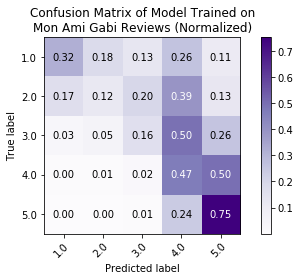

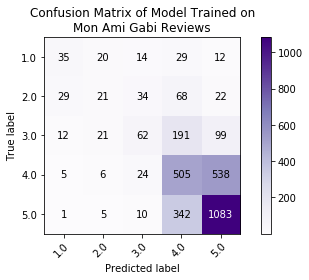

In [15]:
for restaurant in most_popular[:1]:
    analyze_business(restaurant, reviews, max_ngram = 2, 
                     min_ngram = 2, pos_or_neg='pos', normalize=True, 
                     title='Confusion Matrix of Model Trained on\nMon Ami Gabi Reviews (Normalized)',
                    cmap = plt.cm.Purples)
    analyze_business(restaurant, reviews, max_ngram = 2,
                     min_ngram = 2, pos_or_neg='pos', normalize=False, 
                     title='Confusion Matrix of Model Trained on\nMon Ami Gabi Reviews',
                    cmap = plt.cm.Purples)
    
    

#### Trigrams Positive

4JNXUYY8wbaaDmk3BPzlWw
Length of Vocabulary: 1003
Logistic Regression Performance: 
Accuracy: 0.508155583438
Normalized confusion matrix
[[ 0.35454545  0.15454545  0.11818182  0.26363636  0.10909091]
 [ 0.16091954  0.14367816  0.13218391  0.36206897  0.20114943]
 [ 0.03116883  0.04415584  0.09350649  0.46493506  0.36623377]
 [ 0.00649351  0.0148423   0.03061224  0.42764378  0.52040816]
 [ 0.00138793  0.00763359  0.0055517   0.25052047  0.73490632]]
4JNXUYY8wbaaDmk3BPzlWw
Length of Vocabulary: 1003
Logistic Regression Performance: 
Accuracy: 0.508155583438
Confusion matrix, without normalization
[[  39   17   13   29   12]
 [  28   25   23   63   35]
 [  12   17   36  179  141]
 [   7   16   33  461  561]
 [   2   11    8  361 1059]]
RESDUcs7fIiihp38-d6_6g
Length of Vocabulary: 1141
Logistic Regression Performance: 
Accuracy: 0.459459459459
Normalized confusion matrix
[[ 0.48909657  0.10280374  0.15264798  0.12461059  0.13084112]
 [ 0.23046875  0.0625      0.26953125  0.21484375  0.2226

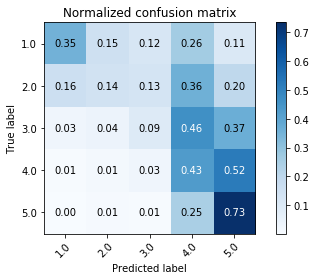

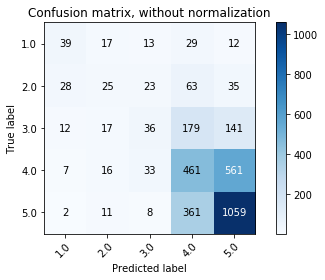

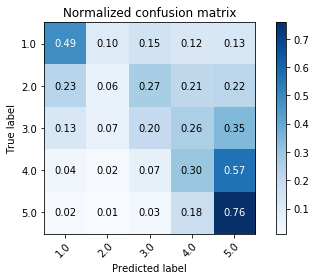

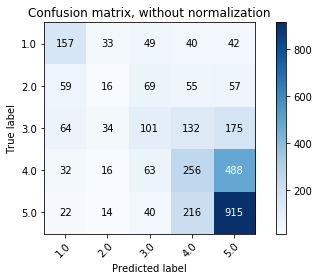

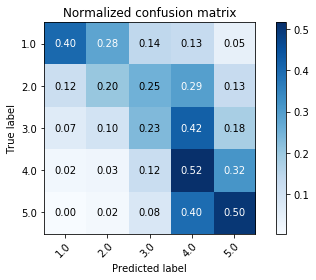

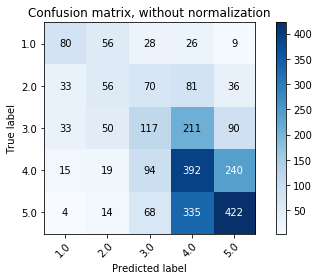

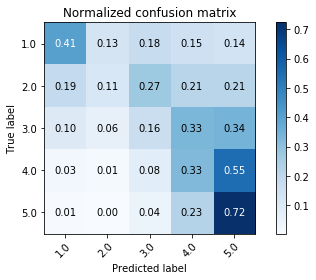

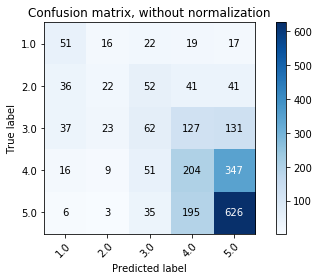

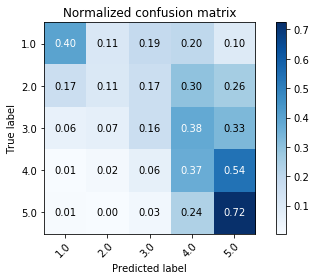

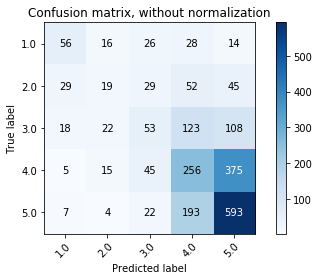

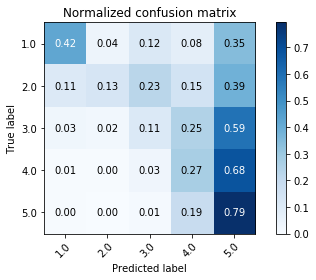

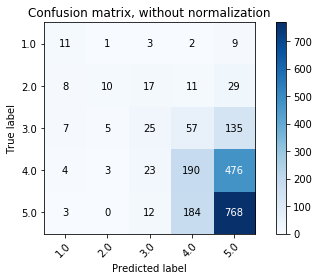

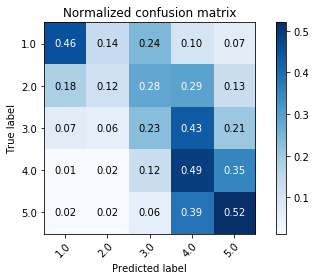

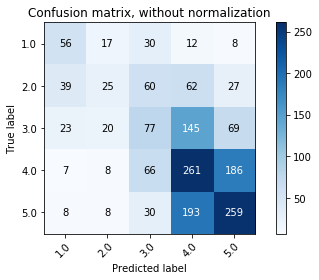

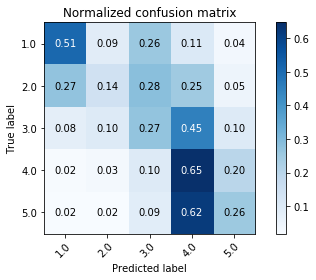

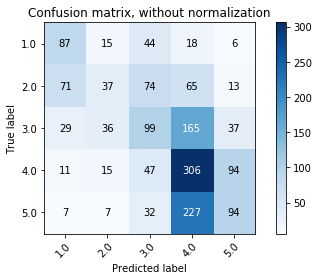

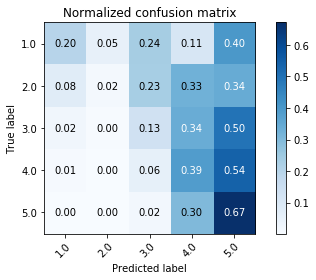

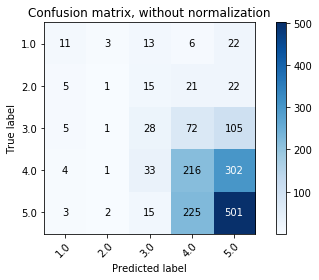

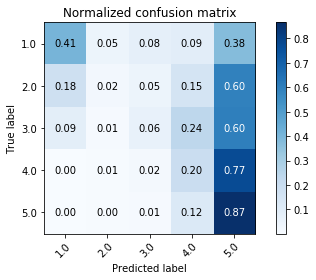

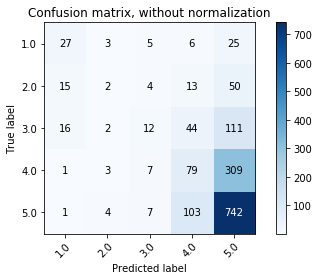

In [19]:
for restaurant in most_popular:
    analyze_business(restaurant, reviews, max_ngram = 3, 
                     min_ngram = 3, pos_or_neg='pos', normalize=True)
    analyze_business(restaurant, reviews, max_ngram = 3,
                     min_ngram = 3, pos_or_neg='pos', normalize=False)

#### Bigrams Negative

4JNXUYY8wbaaDmk3BPzlWw
Length of Vocabulary: 8898
Logistic Regression Performance: 
Accuracy: 0.591593475533
Normalized confusion matrix
[[  3.72727273e-01   2.09090909e-01   1.45454545e-01   2.09090909e-01
    6.36363636e-02]
 [  1.32183908e-01   1.95402299e-01   3.04597701e-01   3.04597701e-01
    6.32183908e-02]
 [  2.07792208e-02   5.97402597e-02   2.51948052e-01   5.19480519e-01
    1.48051948e-01]
 [  2.78293135e-03   2.78293135e-03   2.87569573e-02   5.29684601e-01
    4.35992579e-01]
 [  6.93962526e-04   2.77585010e-03   3.46981263e-03   1.99861207e-01
    7.93199167e-01]]
4JNXUYY8wbaaDmk3BPzlWw
Length of Vocabulary: 8898
Logistic Regression Performance: 
Accuracy: 0.591593475533
Confusion matrix, without normalization
[[  41   23   16   23    7]
 [  23   34   53   53   11]
 [   8   23   97  200   57]
 [   3    3   31  571  470]
 [   1    4    5  288 1143]]


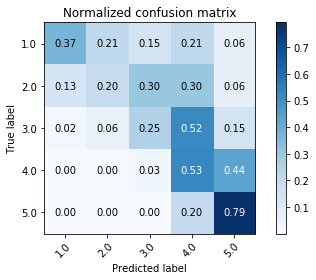

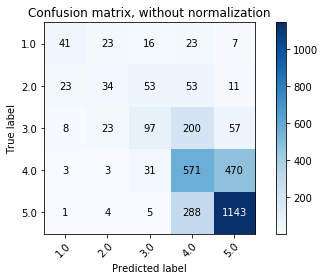

In [17]:
for restaurant in most_popular[:1]:
    analyze_business(restaurant, reviews, max_ngram = 2, 
                     min_ngram = 1, pos_or_neg='neg', normalize=True)
    analyze_business(restaurant, reviews, max_ngram = 2,
                     min_ngram = 1, pos_or_neg='neg', normalize=False)

#### Trigrams Negative

4JNXUYY8wbaaDmk3BPzlWw
Length of Vocabulary: 9901
Logistic Regression Performance: 
Accuracy: 0.590025094103
Normalized confusion matrix
[[  3.72727273e-01   2.09090909e-01   1.45454545e-01   2.09090909e-01
    6.36363636e-02]
 [  1.32183908e-01   1.83908046e-01   3.16091954e-01   2.98850575e-01
    6.89655172e-02]
 [  2.07792208e-02   5.71428571e-02   2.46753247e-01   5.22077922e-01
    1.53246753e-01]
 [  2.78293135e-03   2.78293135e-03   2.78293135e-02   5.25974026e-01
    4.40630798e-01]
 [  6.93962526e-04   2.08188758e-03   3.46981263e-03   1.98473282e-01
    7.95281055e-01]]
4JNXUYY8wbaaDmk3BPzlWw
Length of Vocabulary: 9901
Logistic Regression Performance: 
Accuracy: 0.590025094103
Confusion matrix, without normalization
[[  41   23   16   23    7]
 [  23   32   55   52   12]
 [   8   22   95  201   59]
 [   3    3   30  567  475]
 [   1    3    5  286 1146]]


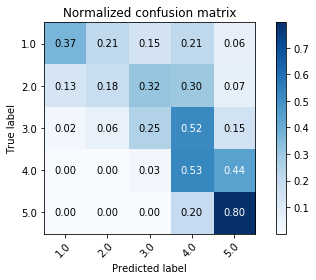

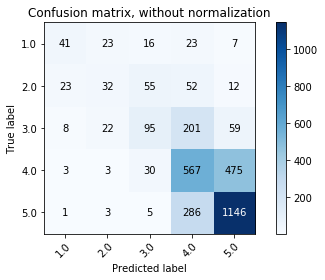

In [18]:
for restaurant in most_popular[:1]:
    analyze_business(restaurant, reviews, max_ngram = 3, 
                     min_ngram = 1, pos_or_neg='neg', normalize=True)
    analyze_business(restaurant, reviews, max_ngram = 3,
                     min_ngram = 1, pos_or_neg='neg', normalize=False)

In [10]:
coef.shape

(5, 5993)

In [11]:
len(feat)

5993

In [64]:
dic = dict(zip(feat, coef[0]))

In [65]:
sorted_by_value = sorted(dic.items(), key=lambda kv: kv[1], reverse = 1)

In [66]:
type(sorted_by_value)

list

In [19]:
sorted_by_value[500:520]

NameError: name 'sorted_by_value' is not defined

In [ ]:
dic = dict(zip(feat, coef[0]))
sorted_by_value = sorted(dic.items(), key=lambda kv: kv[1], reverse = 1)
sorted_by_value[:20]

In [7]:
def analyze_business2(popular_id, data):
    subset = np.logical_and(data['Chinese'] == 1, data['city_Las Vegas'] ==1)
    data_sample = data[subset]
    data_text = data_sample['text'].copy()

    data_stars = data_sample['stars'].copy()
    data_stars = data_stars - 1

    clean_data = data_sample.drop(['Unnamed: 0', 'Unnamed: 0.1', 'business_id', "date", 'text',
                      'review_id', 'stars', 'user_id', 'name', 'Unnamed: 0_y',
                      'postal_code', "BestNights_business_id", "Music", 'latitude',
                      'longitude'],
                axis = 1)

    clean_data.rename({'stars.1': 'avg_stars'}, inplace =True)
    cols = clean_data.columns
    clean_data = np.nan_to_num(clean_data)
    clean_data = pd.DataFrame(clean_data)

    data_sparse = sparse.csr_matrix(clean_data.astype(float))

    vectorizer = TfidfVectorizer(stop_words = "english",
                                max_df = 0.7,
                                min_df = .001,
                                token_pattern = '[A-Za-z][A-Za-z]+',
                                ngram_range = (3,3))

    tfidf = vectorizer.fit_transform(data_text)
    full_sparse_matrix = sparse.hstack([data_sparse, tfidf])

    text_features = vectorizer.get_feature_names()
    # text_features = [w + '_' for w in text_features]
    nontext_features = cols

    features = np.concatenate((np.array(nontext_features, dtype = np.object), text_features), axis = None)
    features = features.tolist()
    # np.savetxt('scratch/tfidf_features_names_digrams_lr_' + popular_id + '.txt', features, delimiter = ',', fmt = '%s' )
    print(popular_id)
    print("Length of Vocabulary: " + str(len(vectorizer.get_feature_names())))
    X_train, X_test, y_train, y_test = train_test_split(full_sparse_matrix, data_stars, 
                                                        test_size = 0.4, random_state = 70)

    LR_clf = LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                                intercept_scaling=1, max_iter=10000, multi_class='multinomial',
                                n_jobs=None, penalty='l2', random_state=50, solver='newton-cg',
                                tol=0.005, verbose=0, warm_start=False)
    LR_clf.fit(X_train, y_train)
    LR_preds = LR_clf.predict(X_test)

    print("Logistic Regression Performance: ")
    print( "Accuracy: "+ str(accuracy_score(LR_preds, y_test)))
    
    feat = features
    coef = LR_clf.coef_
    
    diff_coef = coef[4] - coef[0]
    diff_dic = dict(zip(feat, diff_coef))
    diff_dic_sorted = sorted(diff_dic.items(), key=lambda kv:kv[1], reverse=1)
    important_features=diff_dic_sorted[:20]
    np.savetxt('tfidf_features_names_bigrams_lr_total_pos_' + popular_id + '.txt', 
               important_features, delimiter = '\n', fmt = '%s' )
    
    diff_coef = coef[4] - coef[0]
    diff_dic = dict(zip(feat, diff_coef))
    diff_dic_sorted = sorted(diff_dic.items(), key=lambda kv:kv[1], reverse=0)
    important_features=diff_dic_sorted[:20]
    np.savetxt('tfidf_features_names_bigrams_lr_total_neg_' + popular_id + '.txt', 
               important_features, delimiter = '\n', fmt = '%s' )
    important_features2 = diff_dic_sorted[-20:]
    np.savetxt('tfidf_features_names_'+ str(max_ngram) + 'grams_lr_total_'+ pos_or_neg +'_' + popular_id + '_2.txt', 
               important_features, delimiter = '\n', fmt = '%s' )


### Chinese Bigrams

In [6]:
analyze_business2('x', reviews)

x
Length of Vocabulary: 3568
Logistic Regression Performance: 
Accuracy: 0.563190525395


NameError: name 'max_ngram' is not defined

### Chinese Trigrams

In [8]:
analyze_business2('x', reviews)

x
Length of Vocabulary: 369
Logistic Regression Performance: 
Accuracy: 0.516334154678


NameError: name 'max_ngram' is not defined

In [8]:
reviews.columns[500:]

Index(['nbrhd_Tower City', 'nbrhd_Tremont', 'nbrhd_Trinity Bellwoods',
       'nbrhd_Troy Hill', 'nbrhd_University', 'nbrhd_University City',
       'nbrhd_University of Toronto', 'nbrhd_Upper Beach', 'nbrhd_Uptown',
       'nbrhd_Verdun', 'nbrhd_Victory Village', 'nbrhd_Vilas',
       'nbrhd_Villa Heights', 'nbrhd_Ville-Marie',
       'nbrhd_Villeray-Saint-Michel-Parc-Extension', 'nbrhd_Wallace Emerson',
       'nbrhd_Warehouse District', 'nbrhd_Waunona', 'nbrhd_West Bank',
       'nbrhd_West Boulevard', 'nbrhd_West Don Lands', 'nbrhd_West End',
       'nbrhd_West Queen West', 'nbrhd_West View', 'nbrhd_Westchester Gardens',
       'nbrhd_Westhaven Trails', 'nbrhd_Westmorland', 'nbrhd_Westmount',
       'nbrhd_Westside', 'nbrhd_Wexford', 'nbrhd_Whiskey Island',
       'nbrhd_Williamson - Marquette', 'nbrhd_Willowdale', 'nbrhd_Willy St',
       'nbrhd_Worthington Park', 'nbrhd_Wychwood', 'nbrhd_Yonge and Eglinton',
       'nbrhd_Yonge and St. Clair', 'nbrhd_Yorkville', 'city_Calgary',
 

### All Data

In [ ]:
data_sample = reviews.sample(frac = 0.1, random_state = 4919)

data_text = data_sample['text'].copy()

stars = data_sample['stars'].copy()
stars = stars - 1
data_sample['compound'] = data_sample['compound'] + 1

data_sample.drop(['Unnamed: 0', 'Unnamed: 0.1', 'business_id', "date", 'text',
                  'review_id', 'stars', 'user_id', 'name', 'Unnamed: 0_y',
                  'postal_code', "BestNights_business_id", "Music", 'latitude',
                  'longitude'],
            axis = 1,
            inplace = True)

data_sample.rename({'stars.1': 'avg_stars'}, inplace =True)
data_sample = np.nan_to_num(data_sample)

data_sparse = sparse.csr_matrix(data_sample.astype(float))

vectorizer = TfidfVectorizer(stop_words = "english",
                            max_df = 0.7,
                            min_df = .001,
                            ngram_range = (1,1),
                            token_pattern = '[A-Za-z][A-Za-z]+')

tfidf = vectorizer.fit_transform(data_text)
full_sparse_matrix = sparse.hstack([data_sparse, tfidf])

print("Length of Vocabulary: " + str(len(vectorizer.get_feature_names())))

X_train, X_test, y_train, y_test = train_test_split(full_sparse_matrix, stars, test_size = 0.4, random_state = 70)
LR_clf = LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                            intercept_scaling=1, max_iter=10000, multi_class='multinomial',
                            n_jobs=None, penalty='l2', random_state=50, solver='newton-cg',
                            tol=0.005, verbose=0, warm_start=False)
LR_clf.fit(X_train, y_train)
LR_preds = LR_clf.predict(X_test)
plot_confusion_matrix(y_test, LR_preds, title = "Confusion Matrix of Model\nTrained on 10% of All Reviews")
print("Logistic Regression Performance: ")
print( "Accuracy: "+ str(accuracy_score(LR_preds, y_test)))

Length of Vocabulary: 4144


Normalized confusion matrix
[[ 0.74111283  0.16726773  0.05504036  0.01648635  0.02009274]
 [ 0.27429699  0.36714356  0.26304884  0.06679822  0.02871238]
 [ 0.05487433  0.13027573  0.41501253  0.32111646  0.07872095]
 [ 0.00703331  0.0124198   0.09510413  0.5250283   0.36041445]
 [ 0.00465171  0.00296018  0.01348526  0.17211324  0.80678962]]


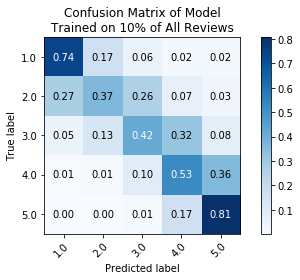

In [20]:
plot_confusion_matrix(y_test+1, LR_preds+1, 
                      title = "Confusion Matrix of Model\nTrained on 10% of All Reviews",
                      normalize = True,
                      cmap= plt.cm.Blues)

Confusion matrix, without normalization
[[ 8631  1948   641   192   234]
 [ 2780  3721  2666   677   291]
 [  810  1923  6126  4740  1162]
 [  205   362  2772 15303 10505]
 [  198   126   574  7326 34341]]


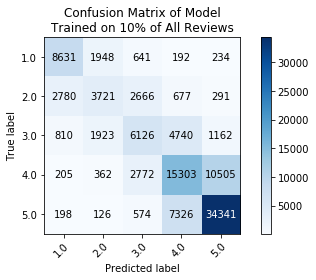

In [21]:
plot_confusion_matrix(y_test+1, LR_preds+1, 
                      title = "Confusion Matrix of Model\nTrained on 10% of All Reviews",
                     cmap= plt.cm.Blues)

In [6]:
cm = np.array([[ 0.74111283,  0.16726773,  0.05504036,  0.01648635,  0.02009274],
 [0.27429699,  0.36714356,  0.26304884,  0.06679822,  0.02871238],
 [0.05487433,  0.13027573,  0.41501253,  0.32111646,  0.07872095],
 [0.00703331, 0.0124198,  0.09510413,  0.5250283,  0.36041445],
 [0.00465171,  0.00296018,  0.01348526,  0.17211324,  0.80678962]]
)

Normalized confusion matrix
[[ 0.74111282  0.16726773  0.05504036  0.01648635  0.02009274]
 [ 0.27429699  0.36714356  0.26304884  0.06679822  0.02871238]
 [ 0.05487433  0.13027573  0.41501253  0.32111646  0.07872095]
 [ 0.00703331  0.0124198   0.09510413  0.52502831  0.36041445]
 [ 0.00465171  0.00296018  0.01348526  0.17211324  0.80678961]]


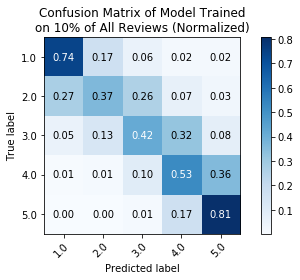

In [12]:
classes = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
cmap=plt.cm.Blues
title= "Confusion Matrix of Model Trained\non 10% of All Reviews (Normalized)"
normalize=True
if True:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')

print(cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()